In [1]:
#torch-specific imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
#torchvision
import torchvision
from torchvision import datasets, models, transforms

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [5]:
device = torch.device('cpu')

In [6]:
dir_data = './data/yoga_poses'

In [7]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [9]:
image_datasets = {x: datasets.ImageFolder(os.path.join(dir_data, x), 
                                          data_transforms[x])
                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=5,shuffle=True, num_workers=0)
                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [10]:
print(class_names)

['tree', 'warrior2']


In [11]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

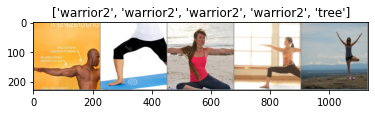

In [13]:
imshow(out, title=[class_names[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

In [16]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [17]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [18]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
model = train_model(model, criterion, optimizer,
                    step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6629 Acc: 0.6138
val Loss: 0.4875 Acc: 0.7400

Epoch 1/24
----------
train Loss: 0.5513 Acc: 0.7328
val Loss: 0.3574 Acc: 0.9267

Epoch 2/24
----------
train Loss: 0.4851 Acc: 0.8042
val Loss: 0.2276 Acc: 0.9600

Epoch 3/24
----------
train Loss: 0.4205 Acc: 0.8386
val Loss: 0.1697 Acc: 0.9733

Epoch 4/24
----------
train Loss: 0.4040 Acc: 0.8360
val Loss: 0.1214 Acc: 0.9800

Epoch 5/24
----------
train Loss: 0.3817 Acc: 0.8228
val Loss: 0.1007 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.3361 Acc: 0.8519
val Loss: 0.0722 Acc: 0.9933

Epoch 7/24
----------
train Loss: 0.2959 Acc: 0.8942
val Loss: 0.0763 Acc: 0.9867

Epoch 8/24
----------
train Loss: 0.3415 Acc: 0.8439
val Loss: 0.0806 Acc: 0.9867

Epoch 9/24
----------
train Loss: 0.3352 Acc: 0.8677
val Loss: 0.0796 Acc: 0.9733

Epoch 10/24
----------
train Loss: 0.3090 Acc: 0.8836
val Loss: 0.0835 Acc: 0.9800

Epoch 11/24
----------
train Loss: 0.2818 Acc: 0.8968
val Loss: 0.0721 Acc: 0.9867

Epoch 12/24
----------
t

In [20]:
# Freeze all but last fully connected layer
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [21]:
# Parameters of newly constructed modules have requires_grad=True by default

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

In [22]:
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [23]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [24]:
# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6447 Acc: 0.6376
val Loss: 0.2078 Acc: 0.9467

Epoch 1/24
----------
train Loss: 0.5142 Acc: 0.7566
val Loss: 0.1062 Acc: 0.9733

Epoch 2/24
----------
train Loss: 0.4286 Acc: 0.8016
val Loss: 0.2034 Acc: 0.9067

Epoch 3/24
----------
train Loss: 0.4723 Acc: 0.8016
val Loss: 0.1053 Acc: 0.9667

Epoch 4/24
----------
train Loss: 0.4077 Acc: 0.8069
val Loss: 0.0893 Acc: 0.9800

Epoch 5/24
----------
train Loss: 0.4533 Acc: 0.7989
val Loss: 0.1118 Acc: 0.9667

Epoch 6/24
----------
train Loss: 0.4525 Acc: 0.7937
val Loss: 0.0751 Acc: 0.9800

Epoch 7/24
----------
train Loss: 0.2952 Acc: 0.8677
val Loss: 0.0716 Acc: 0.9800

Epoch 8/24
----------
train Loss: 0.3138 Acc: 0.8571
val Loss: 0.0762 Acc: 0.9800

Epoch 9/24
----------
train Loss: 0.2770 Acc: 0.8889
val Loss: 0.0702 Acc: 0.9800

Epoch 10/24
----------
train Loss: 0.3765 Acc: 0.8624
val Loss: 0.0768 Acc: 0.9733

Epoch 11/24
----------
train Loss: 0.3408 Acc: 0.8545
val Loss: 0.0786 Acc: 0.9733

Ep

In [ ]:

# save the model locally so you can upload it to boon.ai
torch.save(model, 'yoga_model.pt')

#model = torch.load('yoga_model.pt')